# Predicting Health Risk Factors Using Community-Level Health Records  

In [1]:
# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import scipy.stats as stats
from sklearn.model_selection import train_test_split , KFold , StratifiedKFold , GridSearchCV , RandomizedSearchCV , cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler , OneHotEncoder , LabelEncoder , OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
import xgboost as xgb
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score , precision_score , f1_score , recall_score , confusion_matrix , classification_report

In [3]:
# Load The Dataset

In [4]:
dataset = pd.read_csv("health_data.csv")

In [5]:
dataset.head(3)

,Name,Gender,Age,Systolic BP,Diastolic BP,Cholesterol,Height (cm),Weight (kg),BMI,Smoker,Diabetes,Health
0,Heidi Williamson,Male,35,129,83,188,169.072096,73.796178,25.816062,False,True,Fair
1,Eric Odom,Male,70,133,95,224,154.188611,70.671522,29.726232,False,False,Fair
2,Kelly Thomas,Male,79,149,88,179,197.514897,97.590268,25.015362,True,True,Bad


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1000 non-null   object 
 1   Gender        1000 non-null   object 
 2   Age           1000 non-null   int64  
 3   Systolic BP   1000 non-null   int64  
 4   Diastolic BP  1000 non-null   int64  
 5   Cholesterol   1000 non-null   int64  
 6   Height (cm)   1000 non-null   float64
 7   Weight (kg)   1000 non-null   float64
 8   BMI           1000 non-null   float64
 9   Smoker        1000 non-null   bool   
 10  Diabetes      1000 non-null   bool   
 11  Health        1000 non-null   object 
dtypes: bool(2), float64(3), int64(4), object(3)
memory usage: 80.2+ KB


In [7]:
# Removing Name Feature

In [8]:
dataset.drop(columns=["Name"],inplace=True)

In [9]:
dataset.describe()

,Age,Systolic BP,Diastolic BP,Cholesterol,Height (cm),Weight (kg),BMI
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,48.834000,129.526000,82.879000,187.715000,175.038446,74.941397,24.919168
std,17.980816,9.532061,6.064911,21.091387,14.395461,14.622998,6.290984
min,18.000000,105.000000,65.000000,140.000000,150.087644,50.011915,13.094723
25%,33.000000,123.000000,80.000000,172.000000,162.805812,62.264152,20.162104
50%,49.000000,130.000000,83.000000,187.000000,175.426060,74.808034,24.164326
75%,64.000000,136.000000,87.000000,203.000000,187.827352,87.518363,28.671465
max,80.000000,150.000000,95.000000,239.000000,199.966307,99.954932,43.806649


# 1. Data Cleaning

In [10]:
# Removing Duplicates Rows

In [11]:
dataset.duplicated().sum()

0

In [12]:
dataset.shape

(1000, 11)

In [13]:
dataset.drop_duplicates()

,Gender,Age,Systolic BP,Diastolic BP,Cholesterol,Height (cm),Weight (kg),BMI,Smoker,Diabetes,Health
0,Male,35,129,83,188,169.072096,73.796178,25.816062,False,True,Fair
1,Male,70,133,95,224,154.188611,70.671522,29.726232,False,False,Fair
2,Male,79,149,88,179,197.514897,97.590268,25.015362,True,True,Bad
3,Female,52,115,76,204,157.223771,82.202776,33.254473,False,False,Fair
4,Male,51,135,82,201,177.370258,57.038726,18.130435,False,False,Fair
...,...,...,...,...,...,...,...,...,...,...,...
995,Female,33,119,79,157,189.907684,55.199601,15.305618,False,False,Good
996,Female,57,127,88,208,183.041461,52.775258,15.751844,False,False,Fair
997,Female,38,124,84,158,185.273872,65.673639,19.132104,False,True,Fair
998,Female,67,129,84,181,152.360401,83.614972,36.019679,False,True,Fair


In [14]:
# Handling Missing values

In [15]:
dataset.isnull().sum()

Gender          0
Age             0
Systolic BP     0
Diastolic BP    0
Cholesterol     0
Height (cm)     0
Weight (kg)     0
BMI             0
Smoker          0
Diabetes        0
Health          0
dtype: int64

In [16]:
# Removing Outliers

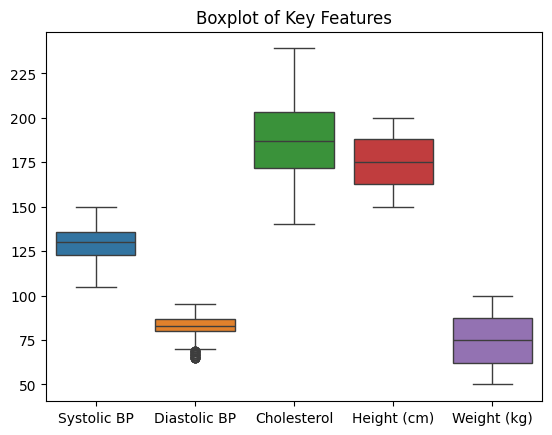

In [17]:
sns.boxplot(data=dataset[["Systolic BP","Diastolic BP","Cholesterol","Height (cm)","Weight (kg)"]])
plt.title("Boxplot of Key Features")
plt.show()

In [18]:
q1 = dataset["Diastolic BP"].quantile(0.25)
q3 = dataset["Diastolic BP"].quantile(0.75)

IQR = q3 - q1

min_range = q1 - (1.5 * IQR)
max_range = q3 + (1.5 * IQR)

dataset["Diastolic BP"] = np.where(dataset["Diastolic BP"] > min_range , dataset["Diastolic BP"] , min_range)
dataset["Diastolic BP"] = np.where(dataset["Diastolic BP"] < max_range , dataset["Diastolic BP"] ,max_range)
dataset["Diastolic BP"] = np.log1p(dataset["Diastolic BP"])
print(f"✅ Diastolic BP capped & log-transformed (replaced original column)")

✅ Diastolic BP capped & log-transformed (replaced original column)


In [19]:
# Spliting The data into train and test

In [20]:
x = dataset.iloc[:,:-1]
y = dataset["Health"]

In [21]:
X_train , X_test , Y_train , Y_test = train_test_split(x  , y , test_size=0.2 , random_state=42 )

In [22]:
# Encoding Chategorical Data

In [23]:
# Nominal for TRUE OR FALSE | 0 OR 1

In [24]:
nominal_columns = ['Gender', 'Smoker', 'Diabetes']

In [25]:
onehot_encoder = OneHotEncoder(drop='first',sparse_output=False)

In [26]:
x_train_ohe = onehot_encoder.fit_transform(X_train[nominal_columns])
x_test_ohe = onehot_encoder.transform(X_test[nominal_columns])

In [27]:
x_train_df = pd.DataFrame(x_train_ohe , columns=onehot_encoder.get_feature_names_out(nominal_columns),index=X_train.index)
x_test_df = pd.DataFrame(x_test_ohe, columns=onehot_encoder.get_feature_names_out(nominal_columns),index=X_test.index)

In [28]:
x_train = pd.concat([X_train.drop(nominal_columns,axis=1),x_train_df], axis=1)
x_test = pd.concat([X_test.drop(nominal_columns,axis=1),x_test_df], axis=1)

In [29]:
# Scaling Numeric Data

In [30]:
numeric_col = dataset.select_dtypes(include=["int64","float64"]).columns
scalar = StandardScaler()
x_train[numeric_col] = scalar.fit_transform(x_train[numeric_col])
x_test[numeric_col] = scalar.transform(x_test[numeric_col])

In [31]:
# Encoding Output Features

In [32]:
label_encoder = LabelEncoder() 

In [33]:
y_train = label_encoder.fit_transform(Y_train)
y_test = label_encoder.transform(Y_test)

# 2. Data Visualization (using Python: pandas, matplotlib, seaborn)

In [34]:
# --- 1. Distribution of Health Status ---

C:\Users\siddi\AppData\Local\Temp\ipykernel_23580\1951895454.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Health", data=dataset, palette='Set2')


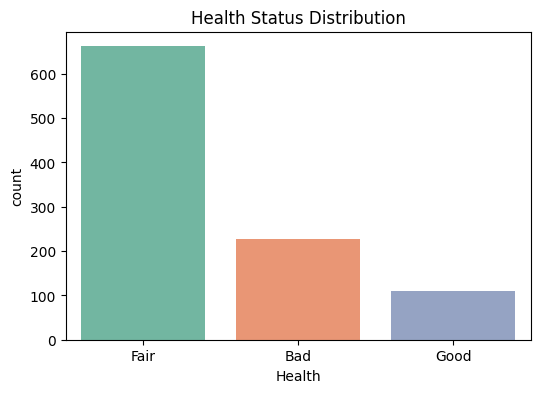

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x="Health", data=dataset, palette='Set2')
plt.title("Health Status Distribution")
plt.show()

In [36]:
# --- 2. Age Distribution by Health ---

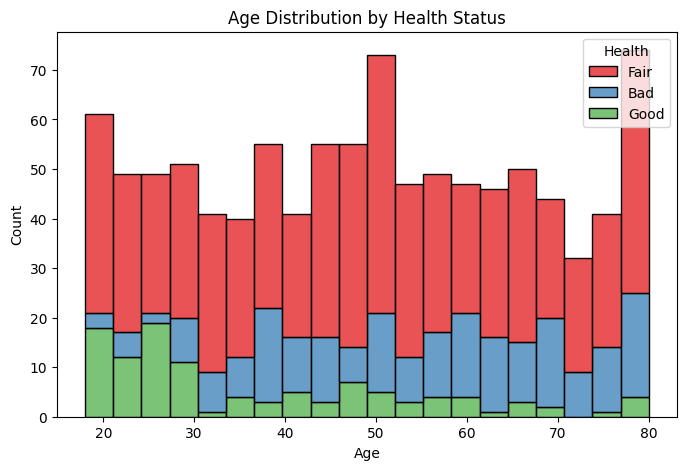

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(data=dataset, x="Age", hue="Health", multiple="stack", bins=20, palette="Set1")
plt.title("Age Distribution by Health Status")
plt.show()

In [38]:
# --- 3. Boxplot: BMI vs Health ---

C:\Users\siddi\AppData\Local\Temp\ipykernel_23580\171256511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Health", y="BMI", data=dataset, palette="Set3")


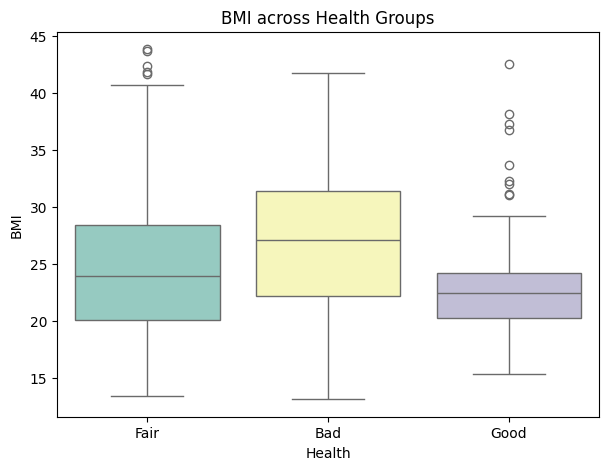

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(x="Health", y="BMI", data=dataset, palette="Set3")
plt.title("BMI across Health Groups")
plt.show()

In [40]:
# --- 5. Smoking vs Health ---

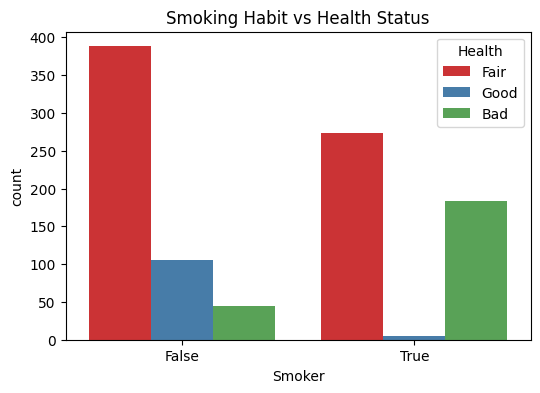

In [41]:
plt.figure(figsize=(6,4))
sns.countplot(x="Smoker", hue="Health", data=dataset, palette="Set1")
plt.title("Smoking Habit vs Health Status")
plt.show()

In [42]:
# --- 6. Diabetes vs Health ---

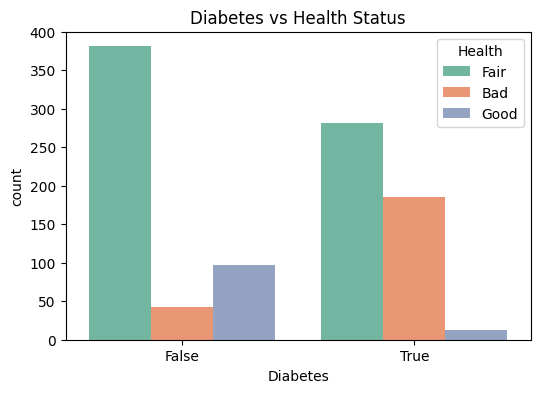

In [43]:
plt.figure(figsize=(6,4))
sns.countplot(x="Diabetes", hue="Health", data=dataset, palette="Set2")
plt.title("Diabetes vs Health Status")
plt.show()

In [44]:
# --- 7. Correlation Heatmap (Numerical Features) ---

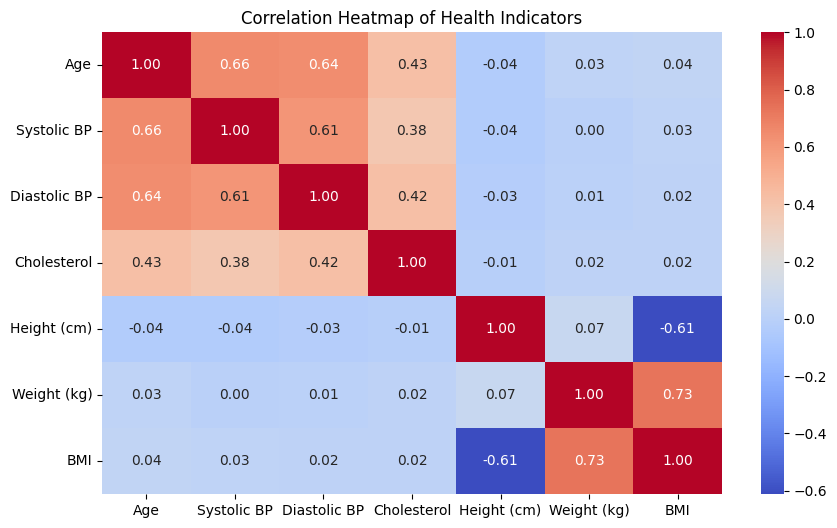

In [45]:
plt.figure(figsize=(10,6))
numeric_cols = ["Age", "Systolic BP", "Diastolic BP", "Cholesterol", "Height (cm)", "Weight (kg)", "BMI"]
sns.heatmap(dataset[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Health Indicators")
plt.show()

# 3. Statistical Analysis

In [46]:
# Descriptive Statistics

In [47]:
print("\nDescriptive Statistics :\n")
dataset.describe()


Descriptive Statistics :



,Age,Systolic BP,Diastolic BP,Cholesterol,Height (cm),Weight (kg),BMI
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,48.834000,129.526000,4.427699,187.715000,175.038446,74.941397,24.919168
std,17.980816,9.532061,0.071309,21.091387,14.395461,14.622998,6.290984
min,18.000000,105.000000,4.255613,140.000000,150.087644,50.011915,13.094723
25%,33.000000,123.000000,4.394449,172.000000,162.805812,62.264152,20.162104
50%,49.000000,130.000000,4.430817,187.000000,175.426060,74.808034,24.164326
75%,64.000000,136.000000,4.477337,203.000000,187.827352,87.518363,28.671465
max,80.000000,150.000000,4.564348,239.000000,199.966307,99.954932,43.806649


In [48]:
# frequency Count For each Chategorical Column

In [49]:
print("\nFrequency Count :\n")
dataset[['Gender', 'Smoker', 'Diabetes', 'Health']].value_counts()


Frequency Count :



Gender  Smoker  Diabetes  Health
Female  False   True      Fair      105
Male    False   False     Fair      101
        True    False     Fair       98
Female  False   False     Fair       94
Male    False   True      Fair       88
Female  True    False     Fair       88
                True      Bad        72
Male    True    True      Bad        69
Female  False   False     Good       50
Male    True    True      Fair       48
        False   False     Good       42
Female  True    True      Fair       40
Male    False   True      Bad        31
        True    False     Bad        26
Female  True    False     Bad        16
        False   True      Bad        14
                          Good       10
        True    False     Good        5
Male    False   True      Good        3
Name: count, dtype: int64

# Model Prediction

In [50]:
# model Training

In [51]:
value , count = np.unique(y_train , return_counts=True)
print(dict(zip(value , count)))

{0: 182, 1: 525, 2: 93}


In [52]:
# Balancing the class distribution

In [53]:
sm = SMOTE(random_state=42)
x_train_final , y_train_final = sm.fit_resample(x_train , y_train)

In [54]:
value2 , count2 = np.unique(y_train_final , return_counts=True)
print(dict(zip(value2 , count2)))

{0: 525, 1: 525, 2: 525}


In [55]:
print(f"Before balancing The Class Distribution {dict(zip(value , count))}")
print(f"After balamcing The Class Distribution {dict(zip(value2 , count2))}")

Before balancing The Class Distribution {0: 182, 1: 525, 2: 93}
After balamcing The Class Distribution {0: 525, 1: 525, 2: 525}


In [56]:
models = {

    "Logistic Regression":LogisticRegression(),
    "SVC":SVC(),
    "KNN":KNeighborsClassifier(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "XGBoost":xgb.XGBClassifier(),
    "AdaBoost":AdaBoostClassifier(),
    "GradientBoost":GradientBoostingClassifier(),
}

In [57]:
for name , model in models.items():
    model.fit(x_train_final , y_train_final)
    y_pred = model.predict(x_test)
    print(f"{name} | Accuraccy Score :{accuracy_score(y_test,y_pred)*100:.3f}")
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model , x_train_final , y_train_final , cv=cv , scoring='accuracy')
    print(f"{name} | Mean Accuracy Score : {np.mean(scores)*100:.3f}\n")

Logistic Regression | Accuraccy Score :69.500
Logistic Regression | Mean Accuracy Score : 81.841

SVC | Accuraccy Score :83.500
SVC | Mean Accuracy Score : 92.254

KNN | Accuraccy Score :67.500
KNN | Mean Accuracy Score : 84.127

Decision Tree | Accuraccy Score :95.500
Decision Tree | Mean Accuracy Score : 96.635

Random Forest | Accuraccy Score :97.500
Random Forest | Mean Accuracy Score : 97.905

XGBoost | Accuraccy Score :98.000
XGBoost | Mean Accuracy Score : 98.159

AdaBoost | Accuraccy Score :92.000
AdaBoost | Mean Accuracy Score : 77.079

GradientBoost | Accuraccy Score :97.000
GradientBoost | Mean Accuracy Score : 98.476



In [58]:
# Training Best Model

In [59]:
best_model = xgb.XGBClassifier(subsample= 0.6,
                               reg_lambda = 2,
                               reg_alpha = 0.01,
                               n_estimators = 500,
                               min_child_weight = 5,
                               max_depth = 3,
                               learning_rate = 0.05,
                               gamma = 0.2,
                               colsample_bytree = 1.0)

In [60]:
best_model.fit(x_train_final , y_train_final)
y_pred = best_model.predict(x_test)

In [61]:
# Model Evaluation

In [62]:
print("Training Score : ",best_model.score(x_train_final , y_train_final)*100)
print("Testing Score : ",best_model.score(x_test , y_test)*100)
print("Accuracy Score :",accuracy_score(y_pred,y_test)*100)
print("Recall Score :",round(recall_score(y_pred,y_test,average='macro')*100,3))
print("Precsion Score :",round(precision_score(y_pred,y_test, average='macro')*100,3))
print("F1 Score :",round(f1_score(y_pred,y_test, average='macro')*100,3))

Training Score :  99.93650793650794
Testing Score :  98.5
Accuracy Score : 98.5
Recall Score : 97.434
Precsion Score : 95.835
F1 Score : 96.606


In [63]:
# Confusion Matrix

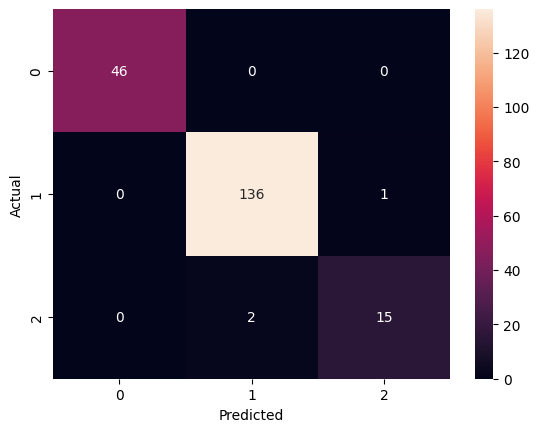

In [64]:
cm = confusion_matrix(y_test , y_pred)
sns.heatmap(data=cm,annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
# Detailed Report

In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.99      0.99      0.99       137
           2       0.94      0.88      0.91        17

    accuracy                           0.98       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.98      0.98      0.98       200



In [67]:
# Hyper Parameter Tuning

In [68]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

In [69]:
# random_search = RandomizedSearchCV(
#     estimator=best_model,
#     param_distributions=param_dist,
#     n_iter=50,             # number of random combinations to try
#     scoring='accuracy',
#     cv=5,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(x_train_final, y_train_final)

In [70]:
# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

In [71]:
# Final Model Training And Evaluation

In [72]:
final_model = best_model = xgb.XGBClassifier(subsample= 0.6,
                               reg_lambda = 2,
                               reg_alpha = 0.01,
                               n_estimators = 500,
                               min_child_weight = 5,
                               max_depth = 3,
                               learning_rate = 0.05,
                               gamma = 0.2,
                               colsample_bytree = 1.0)


In [73]:
final_model.fit(x_train_final , y_train_final)
y_pred = final_model.predict(x_test)

In [80]:
print(f"Accuracy Of Final Model : {accuracy_score(y_pred , y_test)*100}%")
print(f"F1 Score Of Final Model : {round(f1_score(y_pred , y_test ,average='macro')*100,2)}%")

Accuracy Of Final Model : 98.5%
F1 Score Of Final Model : 96.61%


In [81]:
# Save The Model , encoder and scalar For Deployment

In [82]:
joblib.dump(final_model,"health_prd_model.pkl")
joblib.dump(onehot_encoder, "health_prd_oh_encoder.pkl")
joblib.dump(label_encoder, "health_prd_label_encoder.pkl")
joblib.dump(scalar, "health_prd_scaler.pkl")

['health_prd_scaler.pkl']

In [77]:
# Importtance Of feature

In [78]:
from sklearn.inspection import permutation_importance

result = permutation_importance(final_model, x_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

         Feature  Importance
6            BMI      0.2405
9  Diabetes_True      0.2275
8    Smoker_True      0.2205
3    Cholesterol      0.1860
1    Systolic BP      0.0205
2   Diastolic BP      0.0130
4    Height (cm)      0.0030
7    Gender_Male      0.0025
0            Age     -0.0010
5    Weight (kg)     -0.0050


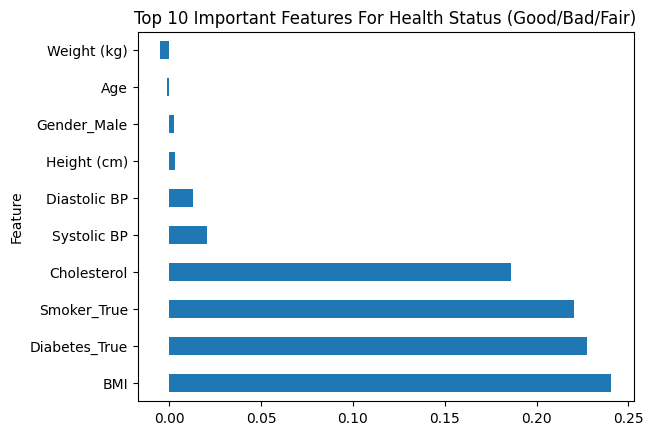

In [83]:
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Important Features For Health Status (Good/Bad/Fair)")
plt.show()
